# DSCI 100 Group 17 Final Project - Predicting Experience Level as a Means to Target Minecraft Players for Recruitment

### Introduction to Data Science in Player Behavior Analysis

Under the direction of Frank Wood, a computer science research team at UBC is gathering information on video game play. Their team has collected player and session data with the hopes that it will be helpful in focusing their recruitment efforts and ensureing that they have sufficient resources (such as server hardware and software licenses) to manage the volume of players they draw in. Here we will address if any correlations can be found between a Minecraft player's habits and the data that has been collected from the open-world Minecraft server and we would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts; specifically **how can session start and end time help to predict the experience level of an individual Minecraft player** so we know where to target advertisements (i.e, at a professional gaming event vs. on kids youtube channels). The two data we sets we use come in the form of CSV files (which we have converted to html files for accessibility), the player's data set with 7 variables; experience, subscribe, hashedEmail, played_hours, name, gender, and age, the sessions data set with 5 variables; hashedEmail, start_time, end_time, original_start_time, and orginial_end_time. Players have around 100 observations while has about 1500 observations. The data is collected from Minecraft game logs and linked to their profile information under the hashedEmail, and we will use this alongside start_time, and end_time to predict experience through reading, wrangling, and clustering. These three key steps: data ingestion, preprocessing, and unsupervised learning, form the foundation of our analysis.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(lubridate)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Methodology

In order to answer this question, we will need to get the start and end time in a meaningful numeric value, which we can use to run a nearest neighbors classification model. We decided that the best way to do this with our skills is to define out start and end time in **minutes since midnight**, which is fairly self-explanatory: how long it has been since midnight.

1) First, we will need to load and merge our datasets so we have each player's hashed email, experience level, and start and end time.

In [2]:
player_url <- "https://raw.githubusercontent.com/mulch-eater-prime/DSCI-Group-17-Project/refs/heads/main/players%20(1).csv"
player <- read_csv(player_url)
sessions_url <- "https://raw.githubusercontent.com/mulch-eater-prime/DSCI-Group-17-Project/03abe89c68205649e71bfa9b8a9cf90efe553b24/sessions%20(1).csv"
sessions <- read_csv(sessions_url)
mashup <- player |>
    select(hashedEmail, experience) |>
    merge(sessions, by = "hashedEmail") |>
    select(hashedEmail:end_time)
mashup

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,experience,start_time,end_time
<chr>,<chr>,<chr>,<chr>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Regular,23/05/2024 00:22,23/05/2024 01:07
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Regular,22/05/2024 23:12,23/05/2024 00:13
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,Pro,28/06/2024 04:28,28/06/2024 04:58
⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,Amateur,28/07/2024 15:36,28/07/2024 15:57
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,Amateur,14/09/2024 15:33,14/09/2024 15:42
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,Beginner,26/04/2024 09:11,26/04/2024 10:23


2) Next, we will need to extract the start and end times into hours and minutes. We will be doing this by separating the values, and then mutating them into dbl variables, as they are currently chr variables, which will not be very useful for the next steps.

In [3]:
mashup_1 <- mashup  |>
    separate(col = start_time, into = c("start_date", "start_time"), sep = " ") |>
    separate(col = end_time, into = c("end_date", "end_time"), sep = " ") |>
    separate(col = start_time, into = c("start_hour", "start_minute"), sep = ":") |>
    separate(col = end_time, into = c("end_hour", "end_minute"), sep = ":") |>
    mutate(start_hour = as.numeric(start_hour),
           start_minute = as.numeric(start_minute),
           end_hour = as.numeric(end_hour),
           end_minute = as.numeric(end_minute)) |>
    select(-start_date, -end_date)
mashup_1

hashedEmail,experience,start_hour,start_minute,end_hour,end_minute
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Regular,0,22,1,7
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Regular,23,12,0,13
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,Pro,4,28,4,58
⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,Amateur,15,36,15,57
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,Amateur,15,33,15,42
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,Beginner,9,11,10,23


3) Mutate the new dataframe to get the start and end time into our desired values: how many minutes have elapsed since midnight.

In [4]:
mashup_2 <- mashup_1 |>
    mutate(start_msm = start_hour*60 + start_minute) |>
    mutate(end_msm = end_hour * 60 + end_minute) |>
    select(experience, start_msm, end_msm, hashedEmail)
mashup_2

experience,start_msm,end_msm,hashedEmail
<chr>,<dbl>,<dbl>,<chr>
Regular,22,67,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832
Regular,1392,13,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832
Pro,268,298,060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967
⋮,⋮,⋮,⋮
Amateur,936,957,fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
Amateur,933,942,fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471
Beginner,551,623,fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1


4) At this point, we want to find the average start and end time for each player, so we grouped the observations by the hashed email - which is unique to each of the players - and found the mean start and end time, in minutes since midnight. We could then merge the data table again to end up with a dataframe with the hashed email, experience level, and the average start and end time for each player. 

In [5]:
player_new <- player |> select(hashedEmail, experience)
msm_new_1 <- mashup_2 |> group_by(hashedEmail) |>
    summarize(start = mean(start_msm), end = mean(end_msm))
msm_new <- player_new |> merge(msm_new_1, by = "hashedEmail")
msm_new

hashedEmail,experience,start,end
<chr>,<chr>,<dbl>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Regular,707,40
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,Pro,268,298
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,Beginner,1261,1272
⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,Amateur,652.8677,649.7548
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,Amateur,933.0000,942.0000
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,Beginner,551.0000,623.0000


5) Finally, we can use this new dataframe to see if there is any notable patterns between start and end time and player experience level.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


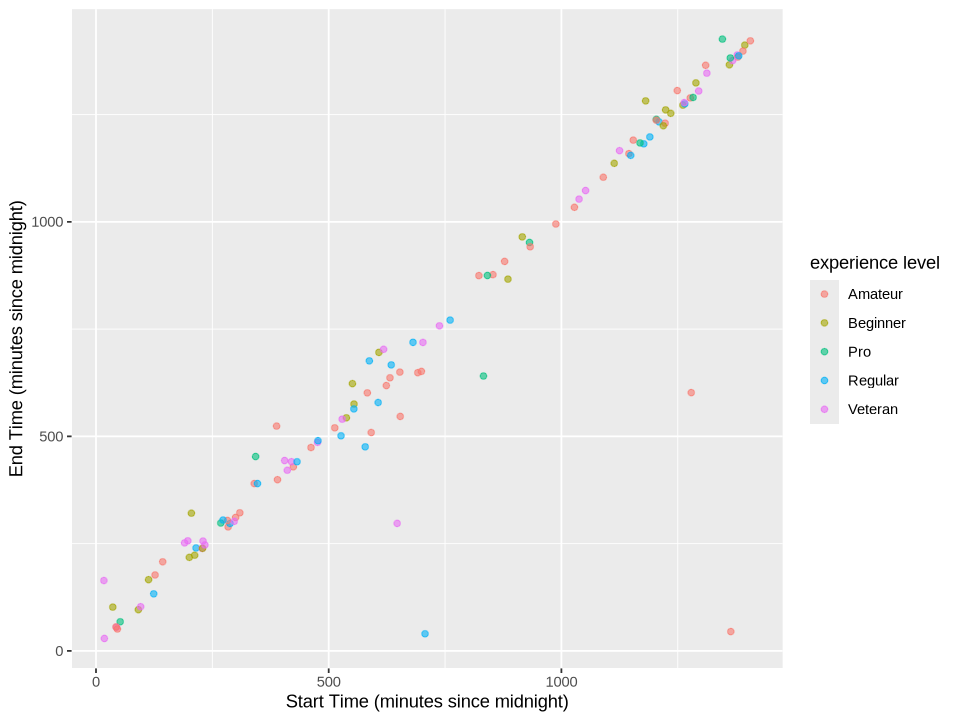

In [6]:
options(repr.plot.width = 8, repr.plot.height = 6)

new_plot <- msm_new |> ggplot(aes(x = start, y = end, color = experience)) +
    geom_point(alpha = 0.6) +
    labs(x = "Start Time (minutes since midnight)", y = "End Time (minutes since midnight)", color = "experience level")
new_plot

In [22]:
set.seed(4321)

minecraft_split <- initial_split(msm_new, prop = 0.75, strata = experience)
minecraft_train <- training(minecraft_split)
minecraft_test <- testing(minecraft_split)

minecraft_recipe <- recipe(experience ~ start + end, data = minecraft_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

minecraft_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

minecraft_vfold <- vfold_cv(minecraft_train, v = 10, strata = experience)

k_vals <- tibble(neighbors = seq(from = 1, to = 75, by = 5))

minecraft_results <- workflow() |>
    add_recipe(minecraft_recipe) |>
    add_model(minecraft_spec) |>
    tune_grid(resamples = minecraft_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")
minecraft_results

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 10 rows.
               ✖ Assigned data has 11 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 11 to size 10.

There were issues with some computations   A: x1

→ B | warning: ✖ No observations were detected in `truth` for level: Pro.
               ℹ Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x2

There were issues with some computations   A: x1   B: x3

There were issues with some computations   A: x1   B: x4

There were issues with some computations   A: x1   B: x4





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.1677329,9,0.05706141,Preprocessor1_Model01
6,accuracy,multiclass,0.2921717,9,0.05308646,Preprocessor1_Model02
11,accuracy,multiclass,0.3393098,9,0.03458111,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
61,accuracy,multiclass,0.320651,9,0.01800623,Preprocessor1_Model13
66,accuracy,multiclass,0.320651,9,0.01800623,Preprocessor1_Model14
71,accuracy,multiclass,0.320651,9,0.01800623,Preprocessor1_Model15


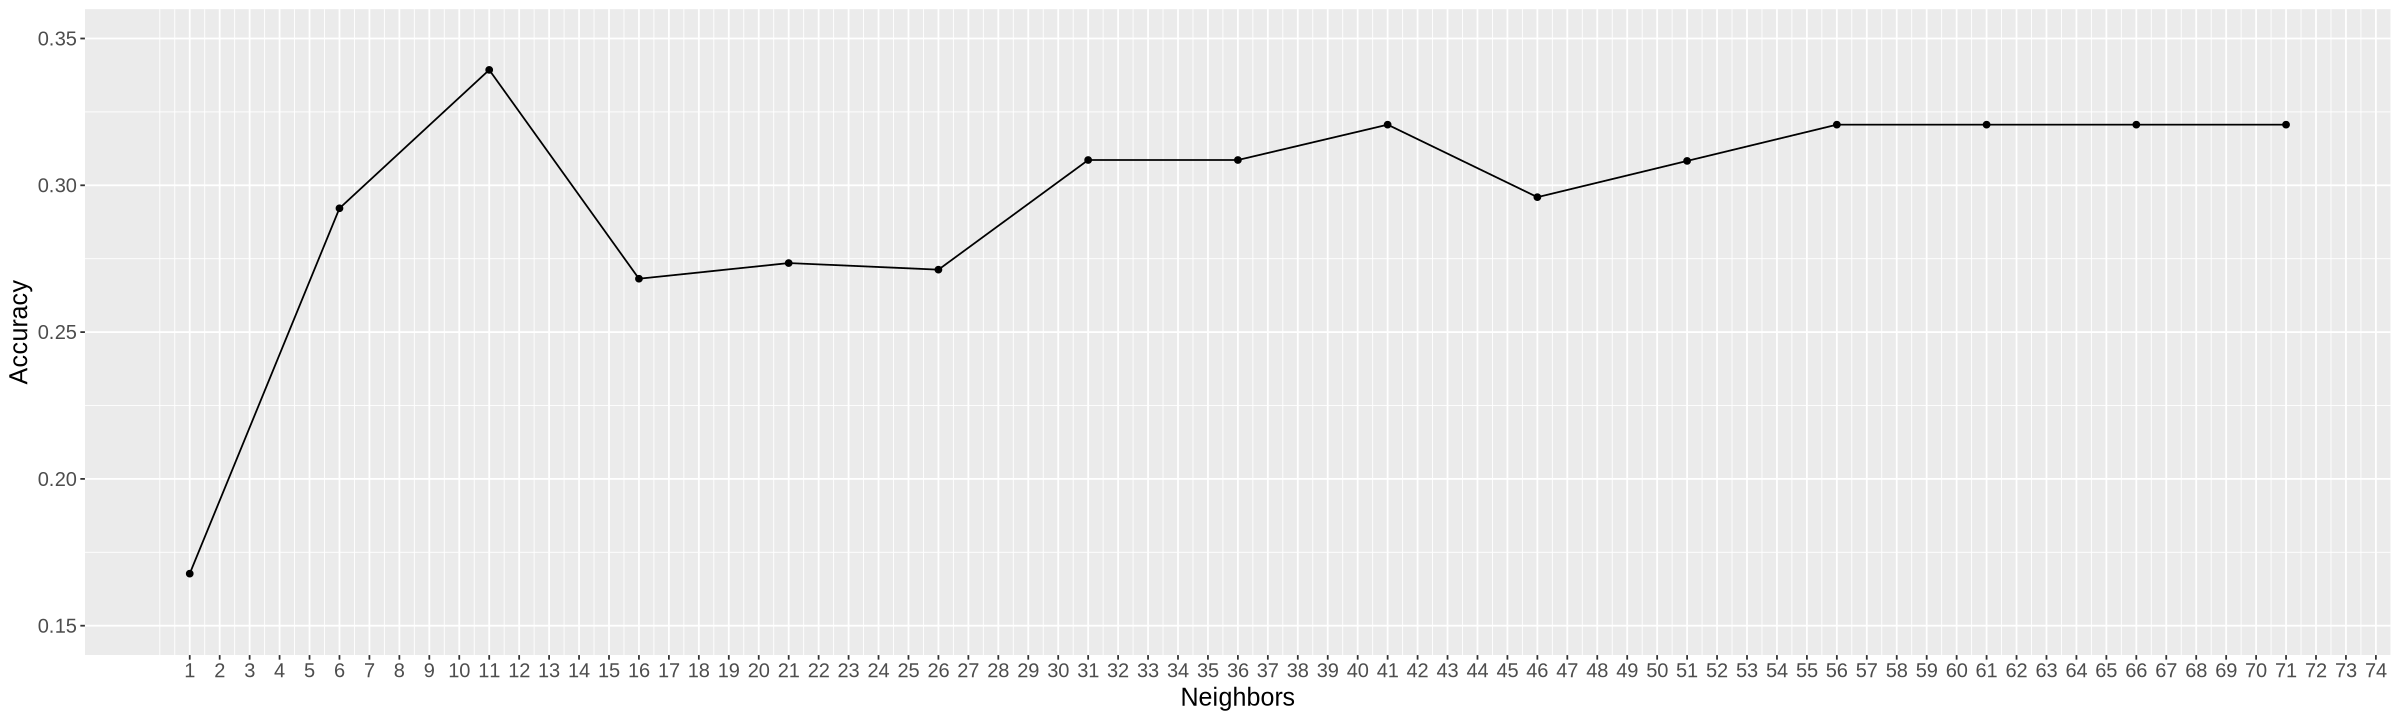

In [23]:

options(repr.plot.width=20, repr.plot.height=6)
minecraft_best_k <- minecraft_results |> ggplot(aes(x = neighbors, y = mean)) +
    geom_point() + geom_line() + 
    labs(x = "Neighbors", y = "Accuracy") +
    theme(text = element_text(size = 15)) +
    scale_x_continuous(breaks = seq(1, 75, by = 1)) + 
    scale_y_continuous(limits = c(0.15, 0.35))
minecraft_best_k
    